Null Values in Dataset:
credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Null Values After Imputation:
credit.policy        0
purpose              0
int.rate             0
installment          0
log.annual.inc       0
dti                  0
fico                 0
days.with.cr.line    0
revol.bal            0
revol.util           0
inq.last.6mths       0
delinq.2yrs          0
pub.rec              0
not.fully.paid       0
dtype: int64

Percentage of Default (not.fully.paid=1): 16.01%
Percentage of Non-Default (not.fully.paid=0): 83.99%


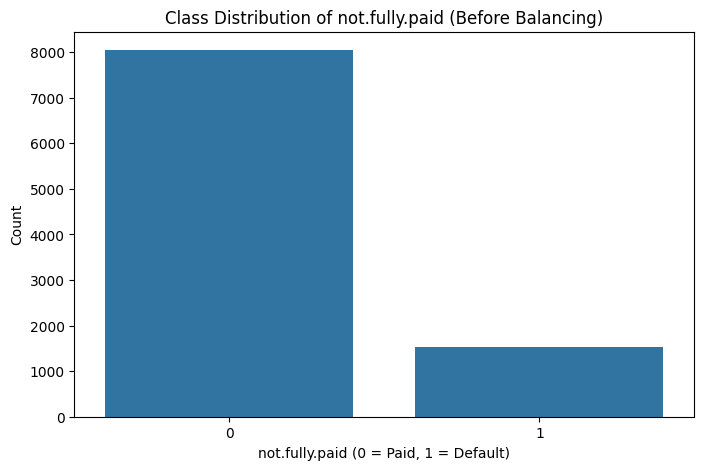

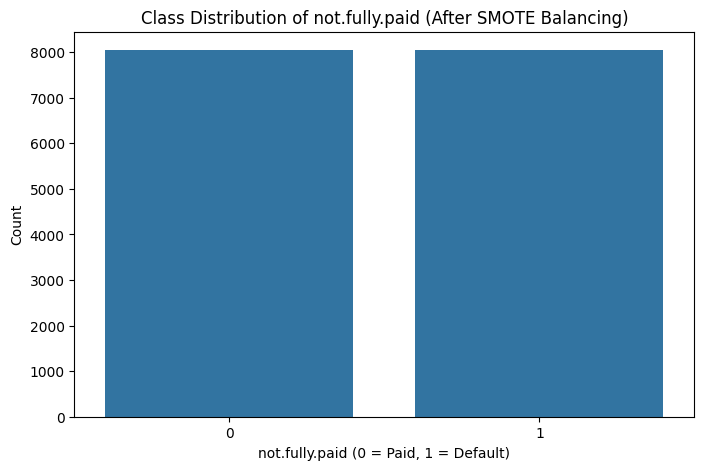

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - Precision: 0.6223 - Recall: 0.5119 - accuracy: 0.5942 - auc: 0.6511 - loss: 0.6609 - val_Precision: 0.6751 - val_Recall: 0.6703 - val_accuracy: 0.6765 - val_auc: 0.7496 - val_loss: 0.5929
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - Precision: 0.6785 - Recall: 0.5924 - accuracy: 0.6596 - auc: 0.7271 - loss: 0.6119 - val_Precision: 0.7053 - val_Recall: 0.6296 - val_accuracy: 0.6858 - val_auc: 0.7633 - val_loss: 0.5829
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.6902 - Recall: 0.5903 - accuracy: 0.6680 - auc: 0.7344 - loss: 0.6023 - val_Precision: 0.6803 - val_Recall: 0.6915 - val_accuracy: 0.6858 - val_auc: 0.7696 - val_loss: 0.5789
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.6851 - Recall: 0.6324 - accuracy: 0.6699 - auc: 0.7376 - loss: 0.6003 - val_Precision: 0.7148 - val_Recall: 0.6202 - val_accuracy: 0.6889 - val_auc: 0.7715 - val_loss: 0.5720
Epoch 5/100
322/322 ━━━━━━━━

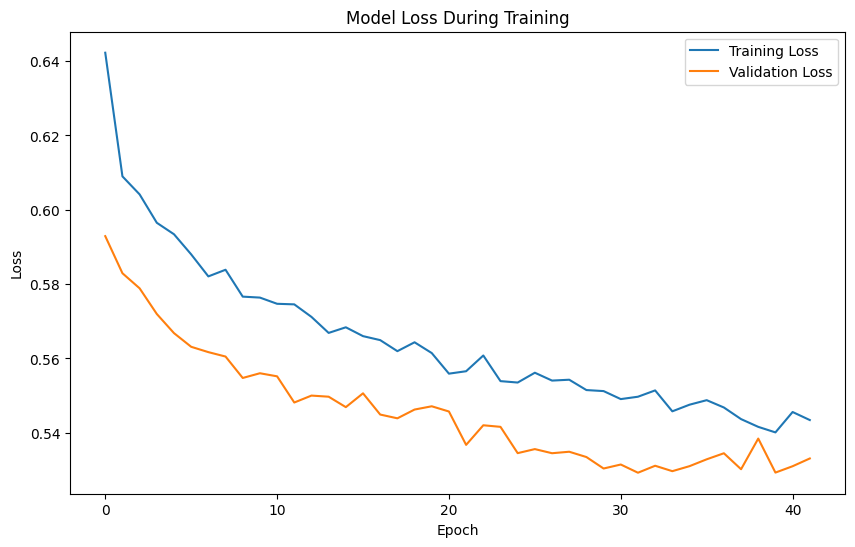

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

# Step 1: Load the dataset
# In Colab, manually upload loan_data.csv or use this code to load it
try:
    df = pd.read_csv('/content/loan_data.csv')
except FileNotFoundError:
    from google.colab import files
    uploaded = files.upload()
    df = pd.read_csv('loan_data.csv')

# Step 2: Check for null values
print("Null Values in Dataset:")
print(df.isnull().sum())

# Handle missing values
# Numerical columns: impute with median
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

# Categorical columns: impute with mode
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])

print("\nNull Values After Imputation:")
print(df.isnull().sum())

# Step 3: Print percentage of default to non-default in not.fully.paid column
default_counts = df['not.fully.paid'].value_counts()
default_percentage = (default_counts[1] / len(df)) * 100
non_default_percentage = (default_counts[0] / len(df)) * 100
print(f"\nPercentage of Default (not.fully.paid=1): {default_percentage:.2f}%")
print(f"Percentage of Non-Default (not.fully.paid=0): {non_default_percentage:.2f}%")

# Plot original class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='not.fully.paid', data=df)
plt.title('Class Distribution of not.fully.paid (Before Balancing)')
plt.xlabel('not.fully.paid (0 = Paid, 1 = Default)')
plt.ylabel('Count')
plt.show()

# Step 4: Balance the dataset using SMOTE
X = df.drop('not.fully.paid', axis=1)
y = df['not.fully.paid']

# Encode categorical variables before SMOTE
le = LabelEncoder()
for col in categorical_cols:
    X[col] = le.fit_transform(X[col])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to DataFrame for easier handling
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='not.fully.paid')

# Step 5: Plot balanced data
plt.figure(figsize=(8, 5))
sns.countplot(x=y_resampled)
plt.title('Class Distribution of not.fully.paid (After SMOTE Balancing)')
plt.xlabel('not.fully.paid (0 = Paid, 1 = Default)')
plt.ylabel('Count')
plt.show()

# Step 6: Scale numerical features
scaler = StandardScaler()
X_resampled[numerical_cols.drop('not.fully.paid')] = scaler.fit_transform(X_resampled[numerical_cols.drop('not.fully.paid')])

# Step 7: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Build deep learning model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall', tf.keras.metrics.AUC()])

# Compute class weights for imbalanced training
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Train model with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_split=0.2, class_weight=class_weight_dict,
                    callbacks=[early_stopping], verbose=1)

# Step 8: Calculate sensitivity (recall)
y_pred = (model.predict(X_test) > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)
sensitivity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(f"\nSensitivity (Recall): {sensitivity:.4f}")

# Step 9: Calculate ROC-AUC
roc_auc = roc_auc_score(y_test, model.predict(X_test))
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Additional: Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()